In [149]:
import numpy as np

In [258]:
true_vals = np.random.rand(100)
true_vals.sort()
print(true_vals)
N = len(true_vals)
n_data = 75 # how many to pick in each dataset
data_1 = []
data_1_idx = np.random.permutation(range(N))[:n_data]
data_2_idx = np.random.permutation(range(N))[:n_data]
data_1_idx.sort()
data_2_idx.sort()

opt = len(set(data_1_idx).intersection(set(data_2_idx)))
print(opt)

[0.00422604 0.01838115 0.03062077 0.04326522 0.05847832 0.08192521
 0.09400492 0.11004297 0.11739024 0.1208319  0.12522801 0.12863482
 0.16237657 0.17969009 0.20360497 0.20721562 0.21101133 0.23620668
 0.26643345 0.26952973 0.28009811 0.28779445 0.29153473 0.29541004
 0.29660608 0.30055436 0.31729629 0.32463818 0.33267173 0.33673967
 0.3502125  0.35510638 0.36117458 0.36185317 0.36997589 0.37844506
 0.39525882 0.39982872 0.40937685 0.43208103 0.45681249 0.45978463
 0.47939477 0.48189455 0.4863295  0.52643865 0.54269862 0.55190753
 0.56257221 0.56266877 0.56366492 0.56751218 0.57968937 0.59689379
 0.61681436 0.62205591 0.62597345 0.62928002 0.63702643 0.64029637
 0.64308593 0.65158718 0.66060219 0.67049319 0.67468932 0.68688242
 0.7010385  0.7031147  0.70670311 0.70750735 0.71069851 0.72766115
 0.72919622 0.73701971 0.74008423 0.7503288  0.75145298 0.80379066
 0.80796357 0.8142412  0.81546517 0.81712325 0.82213497 0.83423464
 0.83582245 0.85803024 0.85849424 0.86308354 0.86447971 0.8707

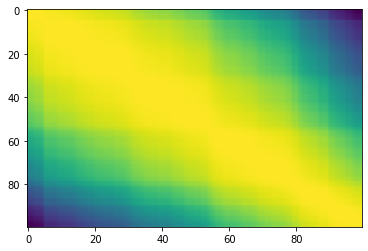

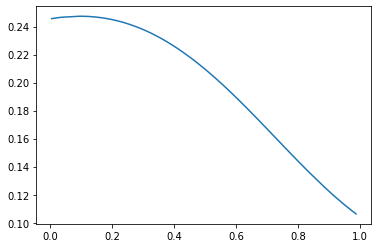

In [151]:
# sample an offset function
alpha = 0.01
gam = 1.
K = np.zeros((N,N),np.double)
for n in range(N):
    for m in range(N):
        K[n,m] = alpha*np.exp(-(1./gam)*(true_vals[n]-true_vals[m])**2)
        
import pylab as plt
%matplotlib inline
plt.imshow(K,aspect='auto')
true_offset_function = np.random.multivariate_normal(np.zeros(N),K)
plt.figure()
plt.plot(true_vals,true_offset_function)

In [152]:
noise_ss = 0.00000
observed_1 = true_vals[data_1_idx]
observed_2 = true_vals[data_2_idx] + true_offset_function[data_2_idx] + np.random.normal(n_data)*np.sqrt(noise_ss)
main_K = np.zeros((n_data,n_data),np.double)
for n in range(n_data):
    for m in range(n_data):
        main_K[n,m] = alpha*np.exp((-1./gam)*(observed_2[n] - observed_2[m])**2)
    

In [153]:
mean_offset_function = np.zeros(n_data)
corrected_data_2 = observed_2 - mean_offset_function

1 58


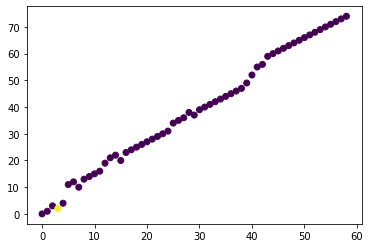

In [215]:
import copy
def match(d1,d2,confirmed_pairs = [], confirmed_non_pairs = [], max_err=0.1):
    if len(confirmed_pairs) > 0:
        confirmed_d1,confirmed_d2 = zip(*confirmed_pairs)
    else:
        confirmed_d1 = []
        confirmed_d2 = []
    matches = []
    d2_copy = list(copy.deepcopy(d2))
    for dd in confirmed_d2:
        d2_copy[dd] = 1e6
    for i,d in enumerate(d1):
        if i in confirmed_d1:
            pos = confirmed_d1.index(i)
            matches.append(confirmed_pairs[pos])
        else:
            di = np.abs([dd - d for dd in d2_copy])
            if len(confirmed_non_pairs) > 0:
                non_matches = list(filter(lambda x: x[0] == i,confirmed_non_pairs))
                if len(non_matches) > 0:
                    nma,nmb = zip(*non_matches)
                    di[np.array(nmb)] = 1e6
            pos = np.argmin(di)
            if di[pos] <= max_err:
                matches.append([i,pos])
                d2_copy[pos] = 1e6
    return np.array(matches)

def eval_matches(matches,data_1_idx,data_2_idx):
    correct = 0
    incorrect = 0
    status = []
    for pos1,pos2 in matches:
        if data_1_idx[pos1] == data_2_idx[pos2]:
            correct += 1
            status.append(1)
        else:
            incorrect += 1
            status.append(-1)
    return correct,incorrect,status

matches = match(observed_1,corrected_data_2)
cor,incor,status = eval_matches(matches,data_1_idx,data_2_idx)
plt.scatter(matches[:,0],matches[:,1],c=status)
print(cor,incor)

In [216]:
def gp_correct(d1,d2,matches,K,alpha=0.01,gam = 1.,noise_ss = 0.00001):
    trainK = K[matches[:,1],:][:,matches[:,1]]
    y = d1[matches[:,0]] - d2[matches[:,1]]
    n = len(y)
    pred = np.dot(np.dot(K[:,matches[:,1]],np.linalg.inv(trainK+noise_ss*np.eye(n))),y)
    return pred
    

pred = gp_correct(observed_1,observed_2,matches,main_K)
corrected_data_2 = observed_2 + pred


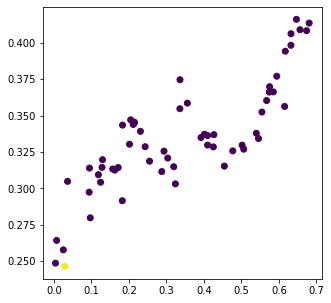

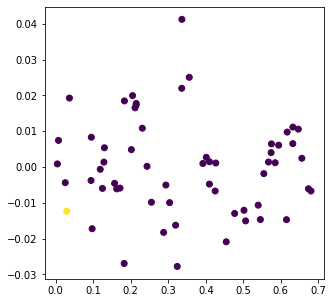

In [217]:
d1 = observed_1[matches[:,0]]
d2 = observed_2[matches[:,1]]
plt.figure(figsize=(5,5))
plt.scatter(d1,d2-d1,c=status)
d1 = observed_1[matches[:,0]]
d2 = corrected_data_2[matches[:,1]]
plt.figure(figsize=(5,5))
plt.scatter(d1,d2-d1,c=status)





1 57


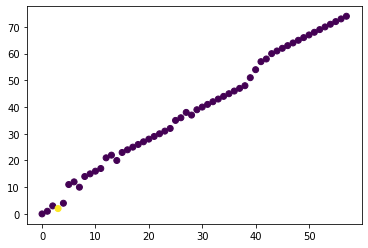

In [218]:
matches = match(observed_1,corrected_data_2)
cor,incor,status = eval_matches(matches,data_1_idx,data_2_idx)
plt.scatter(matches[:,0],matches[:,1],c=status)
print(cor,incor)

In [219]:
def check_pair(pair,data_1_idx,data_2_idx):
    i1,i2 = pair
    if data_1_idx[i1] == data_2_idx[i2]:
        return True
    else:
        return False

In [220]:
for pair in matches:
    print(check_pair(pair,data_1_idx,data_2_idx))

False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [255]:
def query_oracle(matches,confirmed_pairs,confirmed_non_pairs,data_1_idx,data_2_idx):
    if len(matches) == 0: # initial condition
        pair = (np.random.choice(len(data_1_idx)),np.random.choice(len(data_2_idx)))
        status = check_pair(pair,data_1_idx,data_2_idx)
        if status:
            confirmed_pairs.append(pair)
        else:
            confirmed_non_pairs.append(pair)
        done = True
    else:
        n = len(matches)
        perm = np.random.permutation(n)
        ok_found = False
        pos = 0
        while not ok_found:
            pair_idx = perm[pos]
            pair = tuple(matches[pair_idx])
            if pair not in confirmed_pairs and pair not in confirmed_non_pairs:
                ok_found = True
            pos += 1
            if pos == len(matches):
                print("All checked!")
                break
        if ok_found:
            status = check_pair(pair,data_1_idx,data_2_idx)
            if status:
                confirmed_pairs.append(pair)
            else:
                confirmed_non_pairs.append(pair)
            done = True
        else:
            done = False
    return confirmed_pairs,confirmed_non_pairs,done

## Main loop

In [262]:
corrected_data_2 = np.copy(observed_2) # initialise
confirmed_pairs = []
confirmed_non_pairs = []
matches = []
all_corr_incorr = []
done = False
for it in range(1500): # 10 iterations
    confirmed_pairs,confirmed_non_pairs,done = query_oracle(matches,confirmed_pairs,confirmed_non_pairs,data_1_idx,data_2_idx)
    if not done:
        print("Stopping, all matches checked")
        break
    matches = match(observed_1,corrected_data_2,
                    confirmed_pairs=confirmed_pairs,
                    confirmed_non_pairs=confirmed_non_pairs)
    cor,incor,status = eval_matches(matches,data_1_idx,data_2_idx)
    pred = gp_correct(observed_1,observed_2,matches,main_K)
    corrected_data_2 = observed_2 + pred
    if it % 20 == 0:
        print(cor,incor,len(confirmed_pairs),len(confirmed_non_pairs))
    all_corr_incorr.append((cor,incor))
        


0 56 0 1
0 53 0 21
0 41 0 41
0 40 0 61
0 39 0 81
0 38 0 101
0 38 0 121
0 38 0 141
0 37 0 161
0 33 0 181
1 32 0 201
1 32 0 221
0 34 0 241
0 35 0 261
0 34 0 281
0 34 0 301
0 34 0 321
0 36 0 341
0 33 0 361
0 28 0 381
0 26 0 401
0 24 0 421
0 24 0 441
0 23 0 461
0 28 0 481
0 28 0 501
0 29 0 521
0 31 0 541
0 41 0 561
0 42 0 581
0 44 0 601
0 45 0 621
0 46 0 641
0 45 0 661
0 44 0 681
0 49 0 701
0 48 0 721
1 47 0 741
1 47 0 761
1 47 0 781
3 46 2 799
3 47 2 819
4 45 3 838
4 48 3 858
4 48 3 878
4 49 3 898
4 50 4 917
4 51 4 937
4 51 4 957
4 51 4 977
5 49 4 997
5 50 4 1017
5 50 4 1037
4 51 4 1057
5 52 5 1076
6 52 6 1095
6 52 6 1115
9 47 7 1134
9 48 8 1153
10 47 8 1173
14 46 9 1192
15 44 14 1207
16 44 15 1226
17 44 15 1246
20 43 15 1266
19 44 17 1284
22 43 17 1304
21 42 18 1323
21 40 20 1341
23 37 23 1358
23 40 23 1378
24 38 23 1398
24 37 24 1417
24 39 24 1437
25 37 24 1457


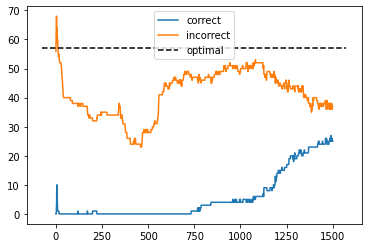

In [263]:
plt.figure()
n_it = len(all_corr_incorr)
c,i = zip(*all_corr_incorr)
plt.plot(range(n_it),c,label='correct')
plt.plot(range(n_it),i,label='incorrect')
xl = plt.xlim()
plt.plot(xl,[opt,opt],'k--',label='optimal')
plt.legend()

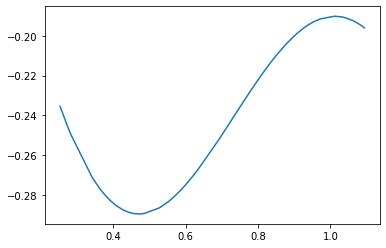

In [264]:
plt.plot(observed_2,pred)